In [ ]:
#hide
# from your_lib.core import *

# gradless




This is an implementation of gradient descent designed to work without access to the exact gradient. To deal with this problem, it uses James Spall's [simultaneous perturbation stochastic approximation (SPSA)](https://www.jhuapl.edu/SPSA/PDF-SPSA/Spall_An_Overview.PDF) to replace the missing gradient. 

SPSA is particularly useful for optimization problems where the objective function itself is noisy, such that the exact gradient cannot be evaluated. For example, if the model at hand is evaluated by simulations rather than exact computations. This is in contrast to more typical applications of stochastic gradient descent, where the gradient can be computed, but noise is introduced through subsampling of the data (e.g. minibatching) or by Monte Carlo integration (e.g. in variational inference). 

## Goals

This is a library I'm developing for use in a research problem of personal interest involving a noisy objective function. As such, it is both still in development and likely to be tailored toward my needs. My principle aim in writing this library is to have a structured, modular, and easy-to-modify framework with a defined API, separate from the actual model I'm working on so that the problem and the tools being applied to the problem are kept separate, hopefully making my research workflow cleaner and more efficient.

I decided to use this as an opportunity to try incorporating literate programming, as accomplished by [```nbdev```](https://github.com/fastai/nbdev), into my development workflow. I've been relying heavily on Jupyter notebooks to document my analyses by interspersing code and narrative. Extending this programming style to script development seemed like a good idea. In brief, ```nbdev``` provides a set of tools for organizing a Python project as set of Jupyter notebooks. All of the actual development takes place in those Jupyter notebooks, rather than an IDE. ```nbdev``` then extracts all code in cells marked with the header ```#export``` to a set of Python scripts and generates documentation from the markdown cells and code cells not labelled ```#export``` or ```#hide```. I am very much enjoying ```nbdev``` and have so far found it a painless and natural approach to writing scripts, and actually getting documentation done (I know I sound like a shill, but it really feels like a phenomenal and transformative tool). This scripts, documentation, and webpage found [here](laptopbiologist.github.io/gradless) were all automatically generated by ```nbdev``` from the ```*.ipynb``` notebooks found in the repositories main directory.  

As this is still in development and geared for personal use, I can't make any general guarantees about its performance or behavior. So if you must use it, use with caution and skepticism.


## To do

* Incorporate just-in-time compilation with JAX to speed up time-consuming functions
* Define a class to organize minibatching. Probably class that wraps datasets along with instructions for how to minibatch the data. This would be called by the ```Model``` class when it evaluates the cost function with data. May need to modify ```Model``` a bit in terms of how it stores and uses ```self.data```.
* Implement some procedures for smart hyperparameter choice

## Similar packages



[noisyopt](https://github.com/andim/noisyopt) provides an implementation of SPSA along with another approach to optimizing noisy objective functions. 



## Example usage

Okay, let's try out a few toy examples, just to demonstrate how the API works. 

First we'll import the packages that we need.



In [ ]:
import numpy
import scipy
from matplotlib import pyplot
import seaborn

from tqdm import tqdm

from gradless import optimizers, costs, gradient, updates

### Simple linear regression

Let's say we are interested in the mean-squared error of a simple linear regression.



Now let's generate 200 data points from a simple linear relationship, with a slope of 2 and an intercept of 5:

$$x \sim normal(0, 5)$$

$$\epsilon \sim normal(0,2)$$

$$y=2x+5+\epsilon$$



Text(0.5, 0, 'x')

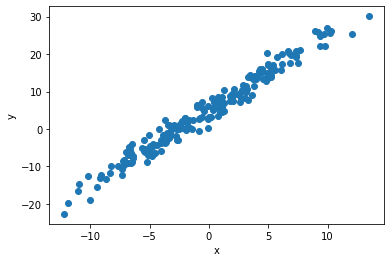

In [ ]:
x=scipy.stats.norm.rvs(0, 5, size=200)
err=scipy.stats.norm.rvs(0, 2, size=200)
slope=2
intercept=5
y=x*slope+intercept +err
pyplot.scatter(x,y)
pyplot.ylabel('y')
pyplot.xlabel('x')


Let's organized this data as a dictionary

In [ ]:
data={'x':x,
     'y':y}

Now we need a function that takes a vector of parameter values and data and uses these to returns a float. Note that it does not matter how the data is organized, so long as the function can interpret it internally.


In [ ]:
def MSE(theta, data):
    x,y=data['x'], data['y']
    y_pred=theta[0]*x+theta[1]
    return numpy.mean((y-y_pred)**2)

Okay, now we'll wrap the cost function and the data in the ```Model``` class

In [ ]:
mse_cost=costs.Model(cost=MSE, data=data)

We'll fit this using the standard gradient descent algorithm described [hera](https://www.jhuapl.edu/SPSA/PDF-SPSA/Spall_An_Overview.PDF). To do this, we're going to construct an instance of the ```GradientDescent``` class, passing it the model, an initial guess, and an update rule.

First, we'll choose an update rule from the ```updates``` submodule, creating an instance of the ```StandardSPSA``` class.

In [ ]:
update_rule=updates.StandardSPSA(max_step=1)

Now we'll create an instance of the ```GradientDescent``` optimizer.

In [ ]:
starts=numpy.array([-9,-9]) #Here's our initial guess
opt_vanilla=optimizers.GradientDescent(x_0 = starts,
                                       cost = mse_cost,
                                       update = update_rule,
                                       gradient=gradient.SPSAGradient(numpy.array([0,0])),
                                       param_stepsize=.1, param_stepdecay=0.5, param_decay_offset=0, 
                                       grad_stepsize=1, grad_stepdecay=.3, )

Note that there are additional parameters that need to be defined. The arguments beginning with ```param``` all control the much the parameters will be updated at each iteration and how this decays over time. The two arguments beginning with ```grad``` control how much the model parameters will be perturbed during the gradient approximation. It may be necessary to tune these parameters to work with a given model.

Now we can optimize the model by iteratively calling the ```update_params``` method of the ```GradientDescent``` instance. Note that we can use the ```tqdm``` library to create a progress bar for the fit

In [ ]:
for i in tqdm(range(10000)):
    opt_vanilla.update_params(gradient_reps=3)


100%|██████████| 10000/10000 [00:03<00:00, 3082.08it/s]


The ```max_step``` argument in ```update_params``` can be used to limit how much parameters are allowed to be updated in each iteration, which can served as heuristic to limit divergences, especially in the early iterations where the learning rate is high. ```gradient_reps``` determines how many gradient approximations are estimated and averaged during each parameter update.



We could also have employed other gradient descent update rules, for example Nestorov-accelerated Adam, which uses the history of prior gradients to make (hopefully) more informed updates.

In [ ]:
update_rule=updates.ADAM( beta1=.9)
opt_NADAM=optimizers.GradientDescent(starts,mse_cost,update_rule,gradient.SPSAGradient(numpy.array([0,0])),param_stepsize=1, param_stepdecay=0.5, param_decay_offset=0, 
                 grad_stepsize=1, grad_stepdecay=.2, )

Because this relies on the history o

In [ ]:

for i in tqdm(range(10000)):
    opt_NADAM.update_params(gradient_reps=3)


100%|██████████| 10000/10000 [00:03<00:00, 3098.22it/s]


In [ ]:
X,Y,Z=[],[],[]
for slope in numpy.arange(-15, 15,.2):

    for intercept in numpy.arange(-15, 15,.2):
        Y.append(intercept)
        X.append(slope)
        Z.append(mse_cost.evaluate([slope,intercept]))


Text(0.5, 1.0, 'Nesterov-accelerated Adam with SPSA')

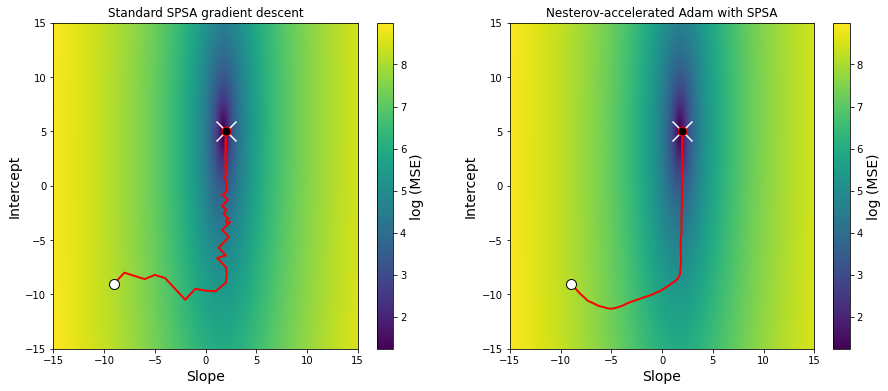

In [ ]:
pyplot.figure(figsize=(15,6))
pyplot.subplot(121)
theta_hist=numpy.array(opt_vanilla.theta_hist)
sc=pyplot.scatter(X,Y, c=numpy.log(Z), zorder=-1)
pyplot.scatter(starts[0], starts[1], c='white', edgecolor='black', s=100)
pyplot.plot(theta_hist[:,0],theta_hist[:,1], c='red', lw=2, zorder=0)
pyplot.scatter(2, 5, marker='x', c='white', s=400)
pyplot.scatter(theta_hist[-1,0],theta_hist[-1,1], marker='o',edgecolor='red', c='black', s=80)

cbar=pyplot.colorbar(sc)
cbar.set_label('log (MSE)', size=14)
pyplot.ylabel('Intercept', size=14)
pyplot.xlabel('Slope', size=14)
pyplot.xlim(-15,15)
pyplot.ylim(-15,15)
pyplot.title('Standard SPSA gradient descent')

pyplot.subplot(122)
theta_hist=numpy.array(opt_NADAM.theta_hist)
sc=pyplot.scatter(X,Y, c=numpy.log(Z), zorder=-1)
pyplot.scatter(starts[0], starts[1], c='white', edgecolor='black', s=100)
pyplot.plot(theta_hist[:,0],theta_hist[:,1], c='red', lw=2, zorder=0)
pyplot.scatter(2, 5, marker='x', c='white', s=400)
pyplot.scatter(theta_hist[-1,0],theta_hist[-1,1], marker='o',edgecolor='red', c='black', s=80)

cbar=pyplot.colorbar(sc)
cbar.set_label('log (MSE)', size=14)
pyplot.ylabel('Intercept', size=14)
pyplot.xlabel('Slope', size=14)
pyplot.xlim(-15,15)
pyplot.ylim(-15,15)
pyplot.title('Nesterov-accelerated Adam with SPSA')

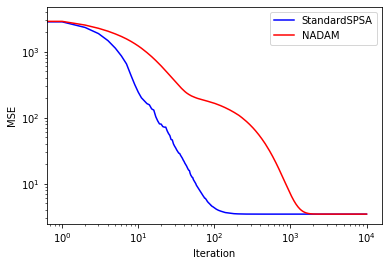

In [ ]:
pyplot.plot(opt_vanilla.cost_history,c='blue', label='StandardSPSA')
pyplot.plot(opt_NADAM.cost_history,c='red', label='NADAM')
pyplot.xscale('log')
pyplot.ylabel('MSE')
pyplot.xlabel('Iteration')
pyplot.yscale('log')
pyplot.legend()

### Fitting the same regression with an intentionally bad loss function

Let's say instead that we decided to optimize this is in a pretty nonsensical fashion. Instead of just computing the loss as

$$\sum_i (y_i - \hat{y}_i)^2$$

we'll add a considerable amount of noise to each prediction and compute it as

$$\epsilon_1,...,\epsilon_n \sim Normal(\mu=0,\sigma =30)$$
$$\sum_i (y_i - (\hat{y}_i + \epsilon_i) )^2$$

This is essentially simulating a noisier dataset from the proposed parameters and the computing the distance between the y-values in the real and simulated data. 

In [ ]:
def MSE_simulated_data(theta, data):
    x,y=data['x'], data['y']
    y_pred=scipy.stats.norm.rvs( theta[0]*x+theta[1], 30.)
    
    return numpy.mean((y-y_pred)**2)

Then we instatiate an instance of the ```GradientDescent``` class with the model, the initial guess, and the update rule.

In [ ]:

mse_sim_cost=costs.Model(MSE_simulated_data, data)
starts=numpy.array([-9,-9])
update_rule=updates.StandardSPSA(max_step=.1)
opt_vanilla=optimizers.GradientDescent(starts,mse_sim_cost,update_rule,
                                       gradient.SPSAGradient(numpy.array([0,0])),
                                       acceptance_rule=updates.BlockWithLocalResiduals(2,100),
                                       param_stepsize=.2, param_stepdecay=0.3, param_decay_offset=0, 
                                       grad_stepsize=1, grad_stepdecay=.2, )

In [ ]:
opt_vanilla.update_params(gradient_reps=100)
for i in tqdm(range(50000)):
    opt_vanilla.update_params(gradient_reps=3)


100%|██████████| 50000/50000 [00:46<00:00, 1069.89it/s]


The ```max_step``` argument in ```update_params``` can be used to limit how much parameters are allowed to be updated in each iteration, which can served as heuristic to limit divergences, especially in the early iterations where the learning rate is high.

In [ ]:

mse_sim_cost=costs.Model(MSE_simulated_data, data)
starts=numpy.array([-9,-9])
update_rule=updates.NADAM( beta1=.9, max_step=.1)
opt_NADAM=optimizers.GradientDescent(starts,mse_sim_cost,update_rule,gradient.SPSAGradient(numpy.array([0,0])),
                                     acceptance_rule=updates.BlockWithLocalResiduals(2,100),
                                     param_stepsize=.2, param_stepdecay=0.3, param_decay_offset=0, 
                 grad_stepsize=1, grad_stepdecay=.2, )

In [ ]:
opt_NADAM.update_params(gradient_reps=100)
for i in tqdm(range(50000)):
    opt_NADAM.update_params(gradient_reps=3)


100%|██████████| 50000/50000 [00:47<00:00, 1044.37it/s]


In [ ]:
X,Y,Z=[],[],[]
for slope in numpy.arange(-15, 15,.2):

    for intercept in numpy.arange(-15, 15,.2):
        Y.append(intercept)
        X.append(slope)
        Z.append(mse_sim_cost.evaluate([slope,intercept]))


Text(0.5, 1.0, 'Nesterov-accelerated Adam with SPSA')

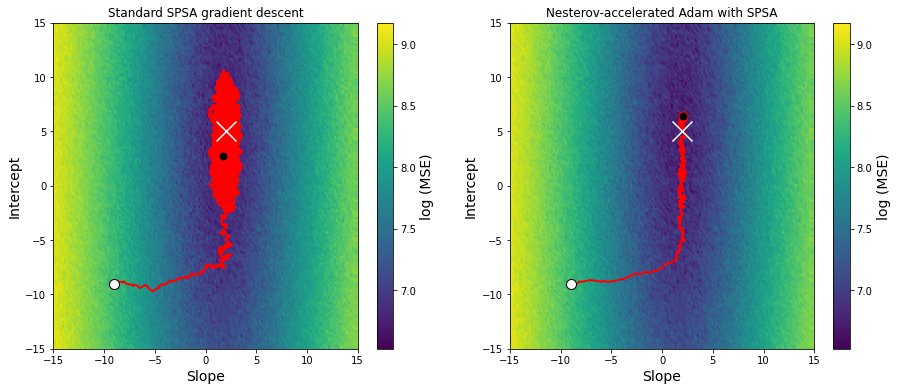

In [ ]:
pyplot.figure(figsize=(15,6))
pyplot.subplot(121)
theta_hist=numpy.array(opt_vanilla.theta_hist)
sc=pyplot.scatter(X,Y, c=numpy.log(Z), zorder=-1)
pyplot.scatter(starts[0], starts[1], c='white', edgecolor='black', s=100)
pyplot.plot(theta_hist[:,0],theta_hist[:,1], c='red', lw=2, zorder=0)
pyplot.scatter(2, 5, marker='x', c='white', s=400)
pyplot.scatter(theta_hist[-1,0],theta_hist[-1,1], marker='o',edgecolor='red', c='black', s=80)

cbar=pyplot.colorbar(sc)
cbar.set_label('log (MSE)', size=14)
pyplot.ylabel('Intercept', size=14)
pyplot.xlabel('Slope', size=14)
pyplot.xlim(-15,15)
pyplot.ylim(-15,15)
pyplot.title('Standard SPSA gradient descent')

pyplot.subplot(122)
theta_hist=numpy.array(opt_NADAM.theta_hist)
sc=pyplot.scatter(X,Y, c=numpy.log(Z), zorder=-1)
pyplot.scatter(starts[0], starts[1], c='white', edgecolor='black', s=100)
pyplot.plot(theta_hist[:,0],theta_hist[:,1], c='red', lw=2, zorder=0)
pyplot.scatter(2, 5, marker='x', c='white', s=400)
pyplot.scatter(theta_hist[-1,0],theta_hist[-1,1], marker='o',edgecolor='red', c='black', s=80)

cbar=pyplot.colorbar(sc)
cbar.set_label('log (MSE)', size=14)
pyplot.ylabel('Intercept', size=14)
pyplot.xlabel('Slope', size=14)
pyplot.xlim(-15,15)
pyplot.ylim(-15,15)
pyplot.title('Nesterov-accelerated Adam with SPSA')
# pyplot.figure(figsize=(8,8))
# sc=pyplot.scatter(X,Y, c=numpy.log(Z), zorder=-1, s=20)
# pyplot.scatter(starts[0], starts[1], c='white', edgecolor='black', s=100)
# pyplot.plot(theta_hist[:,0],theta_hist[:,1], c='red', lw=2, zorder=0)
# pyplot.scatter(theta_hist[-1,0],theta_hist[-1,1], c='red', lw=2, zorder=0)
# pyplot.scatter(2, 5, marker='x', c='white', s=200)

# cbar=pyplot.colorbar(sc)
# cbar.set_label('log (MSE)', size=14)
# pyplot.ylabel('Intercept', size=14)
# pyplot.xlabel('Slope', size=14)
# pyplot.xlim(-15,15)
# pyplot.ylim(-15,15)

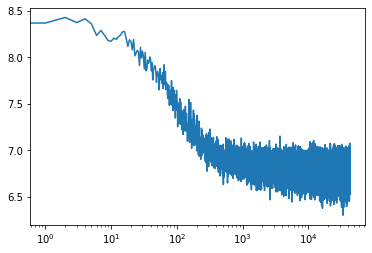

In [ ]:
pyplot.plot(numpy.log(opt_NADAM.cost_history))
pyplot.xscale('log')

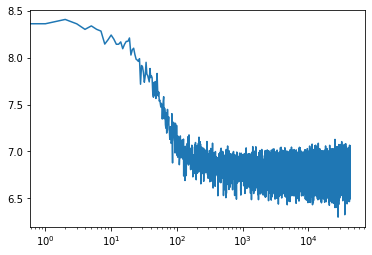

In [ ]:
pyplot.plot(numpy.log(opt_vanilla.cost_history))
pyplot.xscale('log')

It's likely that choosing different parameters for the step size of the standard SPSA gradient descent would lead to better performance.

### High dimensional model

In [ ]:
ndim=200
means=scipy.stats.norm.rvs(0, 5, size=ndim)
sd=numpy.abs(scipy.stats.norm.rvs(0,10, size=ndim))
data=scipy.stats.norm.rvs(means, sd, size=(100,ndim))
true_param=numpy.zeros(2*ndim)
true_param[::2]=means
true_param[1::2]=numpy.log2(sd)

In [ ]:
import jax.numpy as jnp
import jax.scipy as jsc
from jax import jit
def evidence_python(theta, data):
    #priors
    mu=theta[::2]
    sd=theta[1::2]

    mu_prior=jsc.stats.norm.logpdf(mu, 0, 10).sum()
    sd_prior=jsc.stats.norm.logpdf(sd, 0, 5).sum()
    
    loglk=jsc.stats.norm.logpdf(data, mu,2.**(sd)).sum()
    return -(mu_prior+sd_prior+loglk)

#Use just-in-time compiling to speed it up
evidence=jit(evidence_python)

Let's choose an intial guese for the optimizaer

In [ ]:
starts=scipy.stats.norm.rvs(0,3, size=means.shape[0]+sd.shape[0])
starts[::2]=scipy.stats.norm.rvs(0,8, size=means.shape[0])

In [ ]:
print (evidence(starts, data))
print (evidence(true_param, data))

4725433300.0
64599.24


In this case, we know the true values, so we can plot out what the negative log-likelihood looks like on a line passing from the initial guess to the true parameter value:

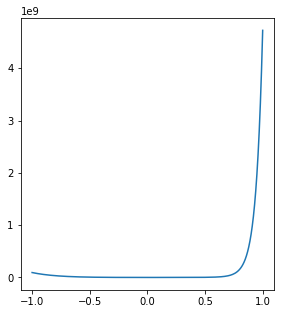

In [ ]:
param_line=true_param[:,None]+numpy.linspace(-1,1,200)*(starts-true_param)[:,None]
cost=[]
noisy_cost=[]
for i in range (200):
    cost.append(evidence(param_line[:,i], data))

pyplot.figure(figsize=(10,5))
pyplot.subplot(121)
pyplot.plot(numpy.linspace(-1,1,200), cost)


If we didn't know what the true parameter value was, we could nonetheless make some reasonable estimate of the magnitude. For example, simulating datasets from the generative model and compute 

In linear scale this, this is quite hard to interpret, and seems likely to give an optimizer some problems. Let's take a look a the log-transform of the negative log-likelihood:

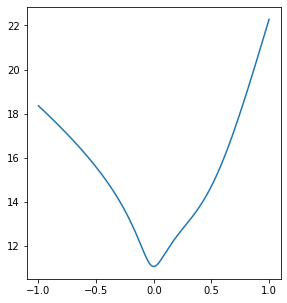

In [ ]:
pyplot.figure(figsize=(10,5))
ax=pyplot.subplot(121)
pyplot.plot(numpy.linspace(-1,1,200), numpy.log(cost))


This looks a lot better and easier to work with. So it will probably be easier to fit the model if we transform the function we're optimizing.

However, while the negative log-likelihood is often positive for many models, this will not necessarily be the case for all models. Probability density functions can return values greater than $1$ if the probability distribution is highly concentrated (for example, beta distributions do this frequently). In that case, the negative log-likelihood maybe negative, so a log-transformation cannot be applied to negative log-likelihoods in general.

An alternative in the inverse hyperbolic sine transformation (arcsineh): $asinh(\frac{x}{2})$. For large positives numbers, this is almost equivalent to the log-transform. For large negative numbers, this is almost equivalent to the negative of the log-transform. For smaller numbers, near zero, transformation is nearly linear and is almost equivalent to dividing them by $2$. That is, this transformation is always somewhere between a log-scale and linear-scale, being almost exactly log-scale for numbers with large magnitudes and almost exactly linear numbers near zero. Importantly, it's a monotonic transformation so it shouldn't change the location of optima, just squish the scales.

/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Text(0.5, 0, 'x')

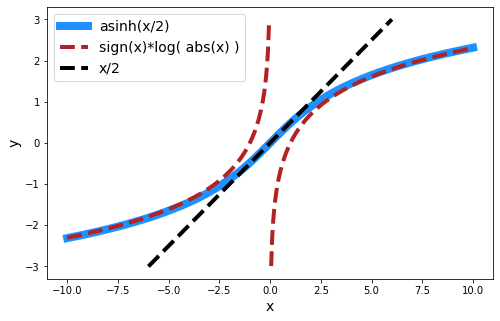

In [ ]:
pyplot.figure(figsize=(8,5))
x=numpy.hstack([numpy.linspace(-10,0,200),numpy.linspace(0,10,200)])
pyplot.plot(x,numpy.arcsinh(x/2), lw=8,c='dodgerblue', label='asinh(x/2)')
pyplot.plot(x, numpy.sign(x)*numpy.log(numpy.abs(x)), c='firebrick',ls='--', lw=4, label='sign(x)*log( abs(x) )')
pyplot.plot([-6,6],numpy.array([-6,6])/2,lw=4, ls='--',c='black', label='x/2')
pyplot.legend(fontsize=14)
pyplot.ylabel('y', size=14)
pyplot.xlabel('x',size=14)


In [ ]:
def evidence_asinh(theta, data):
    #priors

    return numpy.arcsinh (evidence(theta,data)/2)



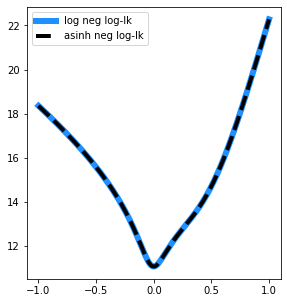

In [ ]:

cost_asinh=[]
noisy_cost_asinh=[]
for i in range (200):
    cost_asinh.append(evidence_asinh(param_line[:,i], data))

pyplot.figure(figsize=(10,5))
pyplot.subplot(121)

pyplot.plot(numpy.linspace(-1,1,200), numpy.log(cost), c='dodgerblue', lw=6,label= 'log neg log-lk')
pyplot.plot(numpy.linspace(-1,1,200), cost_asinh, c='black',ls='--' ,lw=4, label='asinh neg log-lk')
pyplot.legend()


To make this noisy, before evaluating the parameters, I'm going to add some noise drawn from $Normal(0,.5)$ to them.

In [ ]:
print (evidence(starts, data))

4725433300.0


In [ ]:
print (starts.shape)

(400,)


In [ ]:
model=costs.Model(evidence_asinh, data)

update_rule=updates.NADAM(beta1=.99,max_step=.05)
opt=optimizers.GradientDescent(starts,model,update_rule,gradient.SPSAGradient([0,1]*ndim),
                               acceptance_rule=updates.BlockWithLocalResiduals(2,100),
                               param_stepsize = 1, param_stepdecay = .4, param_decay_offset = 0, 
                               grad_stepsize = 1, grad_stepdecay = .2, )

In [ ]:
# grad_test=gradient.SPSAGradient()

/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


(0.0, 1.044256485250772)

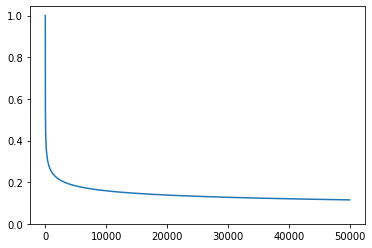

In [ ]:
pyplot.plot(opt.grad_stepsize/numpy.arange(50000)**opt.grad_stepdecay)
pyplot.ylim(0)

/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


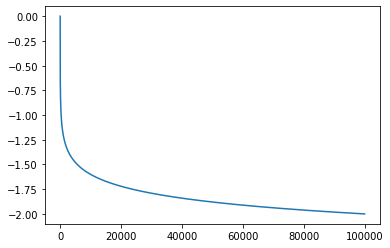

In [ ]:
pyplot.plot(numpy.log10(opt.param_stepsize/(opt.param_decay_offset+numpy.arange(100000))**opt.param_stepdecay))
# pyplot.ylim(0)



In [ ]:
# grad_test.evaluate(post_proxy, starts,1)

In [ ]:
from tqdm import tqdm

In [ ]:
slopes, intercepts=[],[]

for i in tqdm(range(50000)):
    opt.update_params(gradient_reps=1, block_val=None)
    if i>201:
        slopes.append(opt.acceptance_rule.slope)
        intercepts.append(opt.acceptance_rule.intercept)

  0%|          | 0/50000 [00:00<?, ?it/s]/home/mpm289/projects/gradless/gradless/gradient.py:99: RuntimeWarning: divide by zero encountered in true_divide
  ghat=(yplus-yminus)/(2*ck*delta)
  5%|▍         | 2397/50000 [00:04<01:37, 488.38it/s]/home/mpm289/projects/gradless/gradless/gradient.py:99: RuntimeWarning: invalid value encountered in true_divide
  ghat=(yplus-yminus)/(2*ck*delta)
100%|██████████| 50000/50000 [01:38<00:00, 506.28it/s]


In [ ]:
expected=numpy.array(slopes)*(numpy.arange(len(slopes)))+numpy.array(intercepts)


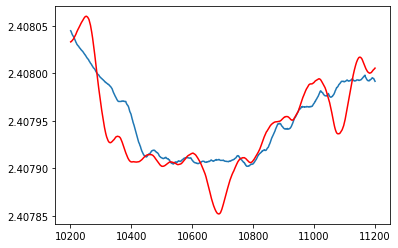

In [ ]:
xmin,xmax=10000,11000
# pyplot.plot(numpy.log10(numpy.exp(opt.cost_history[10000:11000])))
pyplot.plot(201+numpy.arange(len(slopes))[xmin:xmax],numpy.log(opt.cost_history)[xmin:xmax])
pyplot.plot(201+numpy.arange(len(slopes))[xmin:xmax],numpy.log( expected)[xmin:xmax], c='red')
# pyplot.xlim(10000,11000)

In [ ]:

for i in tqdm(range(100000)):
    opt.update_params(gradient_reps=1 )


  0%|          | 0/100000 [00:00<?, ?it/s]/home/mpm289/projects/gradless/gradless/gradient.py:99: RuntimeWarning: divide by zero encountered in true_divide
  ghat=(yplus-yminus)/(2*ck*delta)
  0%|          | 51/100000 [00:00<03:19, 502.23it/s]/home/mpm289/projects/gradless/gradless/gradient.py:99: RuntimeWarning: invalid value encountered in true_divide
  ghat=(yplus-yminus)/(2*ck*delta)
100%|██████████| 100000/100000 [03:15<00:00, 511.57it/s]


In [ ]:
# for i in tqdm(range(50000)):
#     opt.update_params(gradient_reps=1, block_val=2, max_step=2 )


In [ ]:
len(opt.theta_hist)

150001

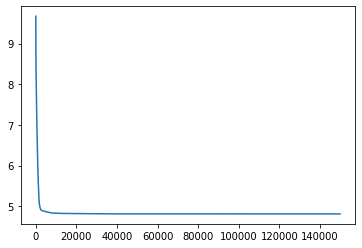

In [ ]:
pyplot.plot(numpy.log10(numpy.exp(opt.cost_history)))

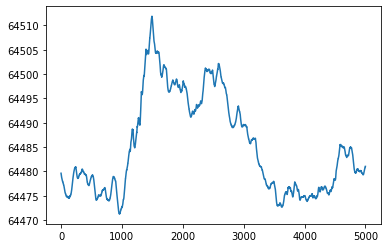

In [ ]:
# pyplot.plot(opt.cost_history[-5000:])
pyplot.plot(numpy.exp(opt.cost_history[-5000:]))

In [ ]:
theta_hist=numpy.array(opt.theta_hist)

In [ ]:
true_param.shape

(400,)

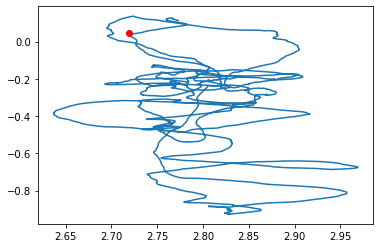

In [ ]:
pyplot.plot(theta_hist[-10000:,1], theta_hist[-10000:,2], zorder=-1)
pyplot.scatter(true_param[1], true_param[2], c='r')

In [ ]:
sd[1]

5.558911899838098

In [ ]:
# theta_hist[-1,:]- theta_hist[-2,:]

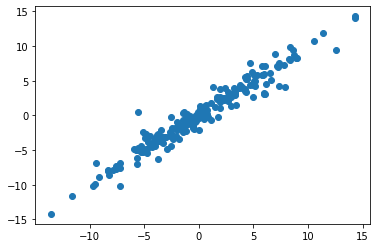

In [ ]:
pyplot.scatter(theta_hist[-1,::2], means)

In [ ]:
max_ind=numpy.argmax(numpy.abs( theta_hist[-1,::2]-means))

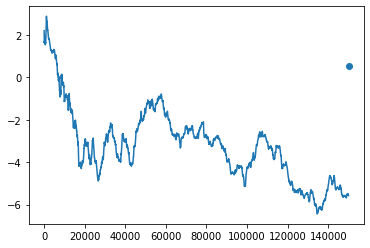

In [ ]:
pyplot.plot(theta_hist[:,2*max_ind],)
pyplot.scatter(theta_hist.shape[0], means[max_ind])

In [ ]:
# data[:,13]

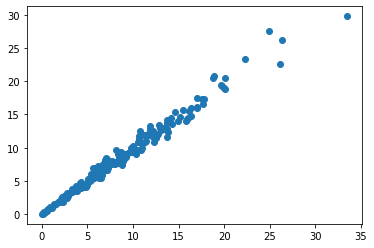

In [ ]:
pyplot.scatter(2.**theta_hist[-1,1::2], (sd))

Let's compare this to the posterior means, inferred using PyMC3. I'll set up the model and draw samples from the posterior using the No-U-Turn Sampler (NUTS).

In [ ]:
import pymc3 as pm
with pm.Model() as model:
    mu=pm.Normal('mu',0,10, shape=ndim)
    std=2.**pm.Normal('sd',0,5, shape=ndim)
    obs=pm.Normal('obs',mu, std, observed=data)
with model:
#     trace=pm.sample()
    MAP=pm.find_MAP()

In [ ]:
mean_mu=MAP['mu']
sd_mu=MAP['sd']

Let's compute the posterior means

In [ ]:
# mean_mu=trace['mu'].mean(0)
# sd_mu=trace['sd'].mean(0)


And now well plot the 

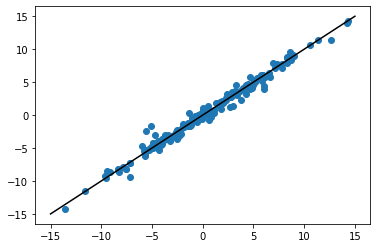

In [ ]:
pyplot.scatter(theta_hist[-1,::2], (mean_mu))
pyplot.plot([-15,15],[-15,15], color='black')

In [ ]:
numpy.argmax(numpy.abs(theta_hist[-1,::2]-(mean_mu)))

143

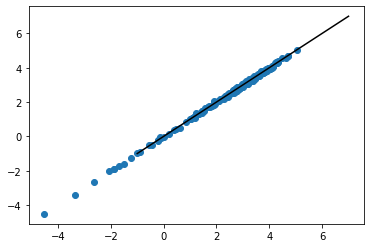

In [ ]:
pyplot.scatter(theta_hist[-1,1::2], (sd_mu))
pyplot.plot([-1,7],[-1,7], color='black')

(400, 400)


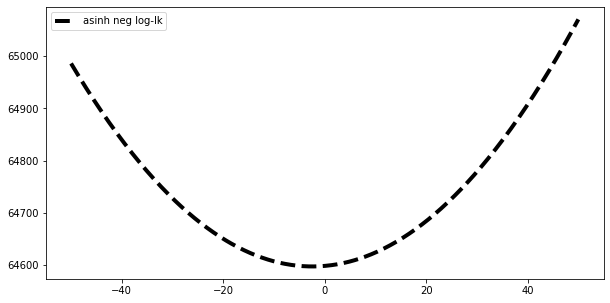

In [ ]:
param_line=numpy.array([true_param]*400)
print (param_line.shape)
xmin=50
param_line[:,2*max_ind]=numpy.linspace(-xmin,xmin,400)
param_line=param_line.T

cost_asinh=[]
noisy_cost_asinh=[]

for i in range (400):
#     print (param_line[:,i].shape)
    cost_asinh.append(evidence(param_line[:,i], data))
#     noisy_cost_asinh.append(numpy.mean([ evidence(param_line[:,i], data) for j in range(5)]))
#     cost_asinh.append( evidence(param_line[:,i], data))
#     noisy_cost_asinh.append(noisy_evidence(param_line[:,i], data))
pyplot.figure(figsize=(10,5))
# ax=pyplot.subplot(121)


pyplot.plot(numpy.linspace(-xmin,xmin,400), cost_asinh, c='black',ls='--' ,lw=4, label='asinh neg log-lk')
pyplot.legend()
# pyplot.subplot(122)

# pyplot.scatter(numpy.linspace(-xmin,xmin,400), noisy_cost_asinh, c='black', label='asinh neg log-lk')
pyplot.legend()

Okay, now let's try this again with the noisy likelihood

In [ ]:
param_schedule=numpy.array([0,1]*ndim)
for i in range (8):
    param_schedule[i::8]=i
#     param_schedule[1::2][i::4]=i+4

In [ ]:
print (param_schedule)

[0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4
 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1
 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6
 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3
 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0
 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5
 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2
 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7
 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4
 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1
 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7]


In [ ]:
model=costs.Model(evidence_asinh, data)

update_rule=updates.NADAM(beta1=.99,max_step=.05)
opt=optimizers.GradientDescent(starts,model,update_rule,gradient.SPSAGradient(param_schedule),
                               acceptance_rule=updates.BlockWithLocalResiduals(2,100),
                               param_stepsize = 1, param_stepdecay = .4, param_decay_offset = 0, 
                               grad_stepsize = 1, grad_stepdecay = .2, )

In [ ]:
# grad_test=gradient.SPSAGradient()

/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


(0.0, 1.044256485250772)

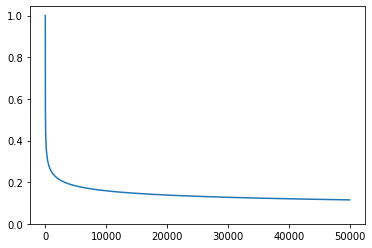

In [ ]:
pyplot.plot(opt.grad_stepsize/numpy.arange(50000)**opt.grad_stepdecay)
pyplot.ylim(0)

/home/mpm289/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


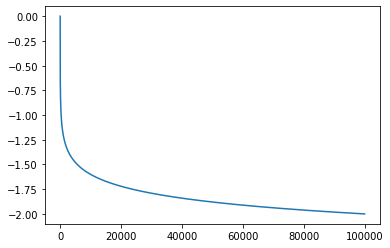

In [ ]:
pyplot.plot(numpy.log10(opt.param_stepsize/(opt.param_decay_offset+numpy.arange(100000))**opt.param_stepdecay))
# pyplot.ylim(0)



In [ ]:
# grad_test.evaluate(post_proxy, starts,1)

In [ ]:
from tqdm import tqdm

In [ ]:
slopes, intercepts=[],[]

for i in tqdm(range(50000)):
    opt.update_params(gradient_reps=1, block_val=None)


100%|██████████| 50000/50000 [05:00<00:00, 166.41it/s]


In [ ]:

for i in tqdm(range(50000)):
    opt.update_params(gradient_reps=1 )


100%|██████████| 50000/50000 [05:01<00:00, 165.67it/s]


In [ ]:
# for i in tqdm(range(50000)):
#     opt.update_params(gradient_reps=1, block_val=2, max_step=2 )


In [ ]:
len(opt.theta_hist)

150001

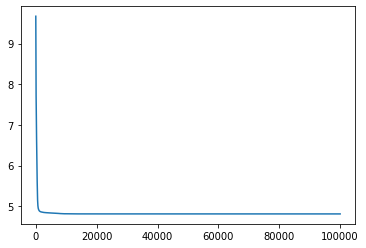

In [ ]:
pyplot.plot(numpy.log10(numpy.exp(opt.cost_history)))

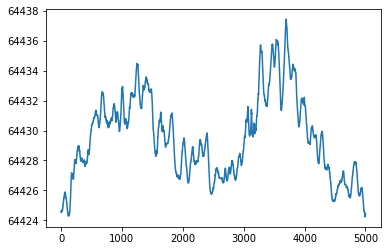

In [ ]:
# pyplot.plot(opt.cost_history[-5000:])
pyplot.plot(numpy.exp(opt.cost_history[-5000:]))

In [ ]:
theta_hist=numpy.array(opt.theta_hist)

In [ ]:
true_param.shape

(400,)

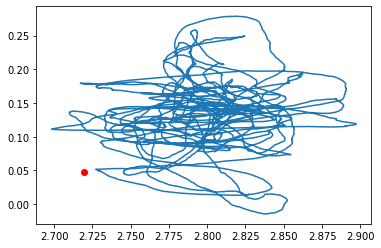

In [ ]:
pyplot.plot(theta_hist[-10000:,1], theta_hist[-10000:,2], zorder=-1)
pyplot.scatter(true_param[1], true_param[2], c='r')

In [ ]:
sd[1]

5.558911899838098

In [ ]:
# theta_hist[-1,:]- theta_hist[-2,:]

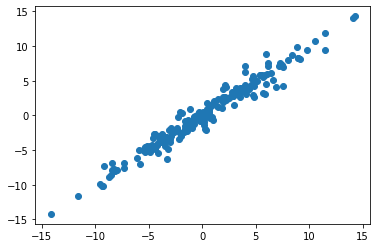

In [ ]:
pyplot.scatter(theta_hist[-1,::2], means)

In [ ]:
max_ind=numpy.argmax(numpy.abs( theta_hist[-1,::2]-means))

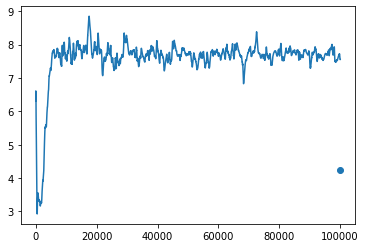

In [ ]:
pyplot.plot(theta_hist[:,2*max_ind],)
pyplot.scatter(theta_hist.shape[0], means[max_ind])

In [ ]:
# data[:,13]

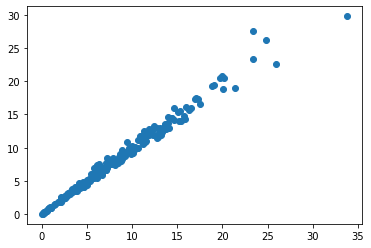

In [ ]:
pyplot.scatter(2.**theta_hist[-1,1::2], (sd))

Let's compare this to the posterior means, inferred using PyMC3. I'll set up the model and draw samples from the posterior using the No-U-Turn Sampler (NUTS).

In [ ]:
import pymc3 as pm
with pm.Model() as model:
    mu=pm.Normal('mu',0,10, shape=ndim)
    std=2.**pm.Normal('sd',0,5, shape=ndim)
    obs=pm.Normal('obs',mu, std, observed=data)
with model:
#     trace=pm.sample()
    MAP=pm.find_MAP()

In [ ]:
mean_mu=MAP['mu']
sd_mu=MAP['sd']

Let's compute the posterior means

In [ ]:
# mean_mu=trace['mu'].mean(0)
# sd_mu=trace['sd'].mean(0)


And now well plot the 

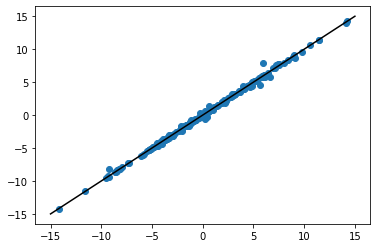

In [ ]:
pyplot.scatter(theta_hist[-1,::2], (mean_mu))
pyplot.plot([-15,15],[-15,15], color='black')

In [ ]:
numpy.argmax(numpy.abs(theta_hist[-1,::2]-(mean_mu)))

139

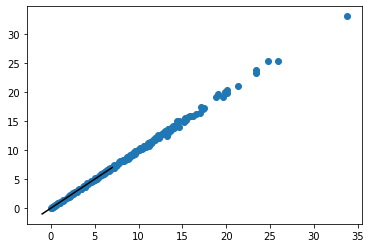

In [ ]:
pyplot.scatter(2.**theta_hist[-1,1::2], 2.**(sd_mu))
pyplot.plot([-1,7],[-1,7], color='black')

(400, 400)


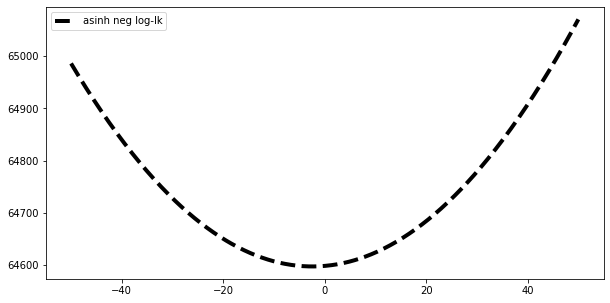

In [ ]:
param_line=numpy.array([true_param]*400)
print (param_line.shape)
xmin=50
param_line[:,2*max_ind]=numpy.linspace(-xmin,xmin,400)
param_line=param_line.T

cost_asinh=[]
noisy_cost_asinh=[]

for i in range (400):
#     print (param_line[:,i].shape)
    cost_asinh.append(evidence(param_line[:,i], data))
#     noisy_cost_asinh.append(numpy.mean([ evidence(param_line[:,i], data) for j in range(5)]))
#     cost_asinh.append( evidence(param_line[:,i], data))
#     noisy_cost_asinh.append(noisy_evidence(param_line[:,i], data))
pyplot.figure(figsize=(10,5))
# ax=pyplot.subplot(121)


pyplot.plot(numpy.linspace(-xmin,xmin,400), cost_asinh, c='black',ls='--' ,lw=4, label='asinh neg log-lk')
pyplot.legend()
# pyplot.subplot(122)

# pyplot.scatter(numpy.linspace(-xmin,xmin,400), noisy_cost_asinh, c='black', label='asinh neg log-lk')
pyplot.legend()

Okay, now let's try this again with the noisy likelihood